<a href="https://colab.research.google.com/github/Ivanchukk/trading/blob/main/MomentumTradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# https://medium.com/analytics-vidhya/algorithmic-momentum-trading-strategy-747e726d04b4
!pip install quantstats yfinance python-binance pandas_ta ta shap
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
%matplotlib inline
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
import pandas_ta as pta

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import graphviz

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.ensemble import RandomForestClassifier




api_key = ""
api_secret = ""
client = Client(api_key, api_secret)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 101 kB/s 
     |████████████████████████████████| 65 kB 1.8 MB/s 
     |████████████████████████████████| 115 kB 35.0 MB/s 
     |████████████████████████████████| 564 kB 36.8 MB/s 
     |████████████████████████████████| 6.4 MB 40.4 MB/s 
     |████████████████████████████████| 63 kB 867 kB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
     |████████████████████████████████| 288 kB 8.2 MB/s 
     |████████████████████████████████| 45 kB 2.1 MB/s 
     |████████████████████████████████| 112 kB 48.6 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 45.6 MB/s 
     |████████████████████████████████| 144 kB 48.8 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=dc4b2287284fa52195bfcf2868e0e5b5ec5090eba09d86194bc7a7a07c7d3e7

# Get data

In [55]:
price = yf.download('goog','1993-01-01','2022-12-29')

[*********************100%***********************]  1 of 1 completed


# Indicators functions

In [3]:
def moving_average(df, periods):
  df['MA'] = df['Close'].rolling(periods).mean()
  return df

In [4]:
def rs_oldi(df, periods = 14, ema = True):
  df['rsi'] = pta.rsi(df['Close'], length = periods)
  return df

In [5]:
def stochastic_oscillator(df, periods):

  high_roll = df["High"].rolling(periods).max()
  low_roll = df["Low"].rolling(periods).min()

  # Fast stochastic indicator
  num = df["Close"] - low_roll
  denom = high_roll - low_roll
  df["%K"] = (num / denom) * 100

  # Slow stochastic indicator
  df["%D"] = df["%K"].rolling(3).mean()

  return df

In [6]:
def psl(df, periods):
  df['psl'] = pta.psl(df['Close'], length = periods)
  return df

In [7]:
def rvi(df, periods):
  df['rvi'] = pta.rvi(df['Close'], length = periods)
  return df

In [8]:
def true_range(df, periods):
  df['true_range'] = pta.true_range(df['High'], df['Low'], df['Close'], length = periods,)
  return df

In [9]:
def pvt(df):
  df['pvt'] = pta.pvt(df['Close'], df['Volume'])
  return df


In [10]:
def pvr(df):
  df['pvr'] = pta.pvr(df['Close'], df['Volume'],)
  return df


In [11]:
def mfi(df):
  df['mfi'] = pta.mfi(df['High'], df['Low'],df['Close'], df['Volume'], )
  return df


In [12]:
def add_indicators(df, periods):
  df = moving_average(df, periods)
  df = rs_oldi(df, periods = 14, ema = True)
  df = stochastic_oscillator(df, periods)
  df = psl(df, periods)
  df = rvi(df, periods)
  df = true_range(df, periods)
  df = pvt(df)
  df = pvr(df)
  df = mfi(df)
  df = df.dropna()
  return df


In [13]:
def make_target(df):
  dff = df.copy()
  dff['returns'] = dff.Close.pct_change()
  dff['target'] = np.where(dff.returns>0, 1, np.where(dff.returns == 0, 2, 0))
  # y= np.where(df['Close'].shift(-1)>df['Close'],1,-1)
  return dff[['Close','returns','target']]

In [14]:
def make_target(df):
  y= np.where(df['Close'].shift(-1)>df['Close'],1,-1)
  where_are_NaNs = np.isnan(y)
  y[where_are_NaNs] = 0
  return y



In [15]:
def drop_na(df):
  return df.dropna()


# Feature Selection

Text(0.5, 0, 'Random Forest Feature Importance')

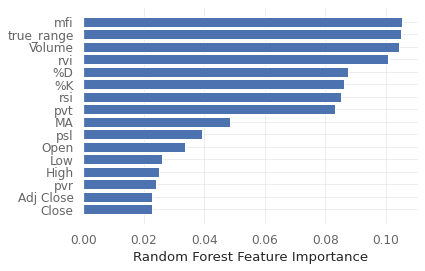

In [16]:
# https://mljar.com/blog/feature-importance-in-random-forest/#:~:text=Random%20Forest%20Built%2Din%20Feature%20Importance&text=It%20is%20a%20set%20of,sets%20with%20similars%20responses%20within.
prices_indicarors = add_indicators(price, 30)

y = make_target(prices_indicarors)

X = pd.DataFrame(prices_indicarors, columns=prices_indicarors.columns)


X_small = X.iloc[:int(X.shape[0]*0.8)]
y_small = y[:int(y.shape[0]*0.8)]

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(prices_indicarors.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# KNN
https://blog.quantinsti.com/machine-learning-k-nearest-neighbors-knn-algorithm-python/

In [17]:
# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model
knn.fit(X_train, y_train)

# Accuracy Score
accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_test = accuracy_score(y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.61
Test_data Accuracy: 0.52


In [18]:
# KNN without low rate features
# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=10)
X_train = X_train.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
X_test = X_test.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

knn = KNeighborsClassifier(n_neighbors=20)

# fit the model
knn.fit(X_train, y_train)

# Accuracy Score
accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_test = accuracy_score(y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.60
Test_data Accuracy: 0.50



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

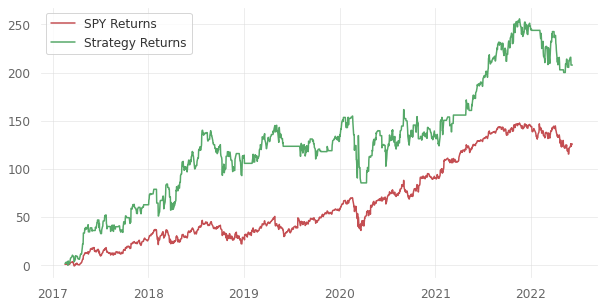

In [19]:
# Predicted Signal
# prices_indicarors = add_indicators(price, 30)

prices_indicarors['Predicted_Signal'] = knn.predict(X.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']))
# prices_indicarors['Predicted_Signal'] = knn.predict(X)
split_percentage = 0.7
split = int(split_percentage*len(prices_indicarors))
# SPY Cumulative Returns
prices_indicarors['returns'] = prices_indicarors.Close.pct_change()
Cumulative_returns = prices_indicarors[split:]['returns'].cumsum()*100

# Cumulative Strategy Returns 
action = []
for index, row in prices_indicarors.iterrows():
  if row.Predicted_Signal == 1:
    action.append(3)
  else:
    action.append(0)

prices_indicarors['action'] = action

prices_indicarors['Startegy_returns'] = prices_indicarors['returns'] * prices_indicarors['action']
Cumulative_Strategy_returns = prices_indicarors[split:]['Startegy_returns'].cumsum()*100

# Plot the results to visualize the performance

plt.figure(figsize=(10,5))
plt.plot(Cumulative_returns, color='r',label = 'SPY Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

# Decision Tree
https://blog.quantinsti.com/decision-tree/

In [20]:
def des_tree(prices_indicarors, predictors_list, depth, leafs):
  X = prices_indicarors[predictors_list]
  y_cls = make_target(prices_indicarors)

  y=y_cls
  print(y)
  X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=0.3, random_state=432, stratify=y)

  print (X_cls_train.shape, y_cls_train.shape)
  print (X_cls_test.shape, y_cls_test.shape)
  clf = DecisionTreeClassifier(criterion='gini', max_depth=depth, min_samples_leaf=leafs)
  clf = clf.fit(X_cls_train, y_cls_train)
  # dot_data = tree.export_graphviz(clf, out_file=None,filled=True,feature_names=predictors_list)
  # graphviz.Source(dot_data)
  y_cls_pred = clf.predict(X_cls_test)
  report = classification_report(y_cls_test, y_cls_pred)
  print(report)
  return y_cls_pred

# plot_retuns(prices_indicarors, des_tree(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

In [21]:
prices_indicarors = add_indicators(price, 30)
prices_indicarors['return'] = price.Close.pct_change().shift(1)
prices_indicarors.head()
prices_indicarors


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,psl,rvi,true_range,pvt,pvr,mfi,return
Date,,,,,,,,,,,,,,,,,
2004-10-04,67.372475,68.179443,66.764748,67.277824,67.277824,13084661,56.191381,80.823583,95.228059,91.529733,70.000000,13.702702,2.136986,5.512138e+08,2.0,79.111752,0.022994
2004-10-05,67.078575,69.006348,65.873093,68.926643,68.926643,15044379,56.672411,82.763207,99.595842,96.020380,70.000000,20.521805,3.133255,5.880840e+08,1.0,79.915586,0.018706
2004-10-06,68.518173,68.966499,67.746071,68.284058,68.284058,13445007,57.207240,79.392861,96.337472,97.053791,70.000000,18.844187,1.220428,5.755496e+08,4.0,80.608900,0.024508
2004-10-07,68.204353,69.678825,68.020042,69.165749,69.165749,14182160,57.752695,80.562489,97.484123,97.805813,70.000000,25.678482,1.658783,5.938617e+08,1.0,81.313719,-0.009323
2004-10-08,69.100990,69.579201,68.254166,68.607841,68.607841,11122133,58.247839,77.562551,94.748421,96.190005,66.666667,23.481866,1.325035,5.848904e+08,4.0,75.078690,0.012912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,2283.760010,2357.959961,2266.159912,2354.919922,2354.919922,1373600,2301.788330,53.193528,55.296351,45.084874,46.666667,50.425861,91.800049,5.548818e+09,2.0,62.376534,0.000859
2022-06-03,2319.850098,2327.290039,2273.360107,2291.280029,2291.280029,1252600,2294.872664,48.392867,53.157803,49.532728,46.666667,48.416366,81.559814,5.545433e+09,4.0,56.355646,0.031620
2022-06-06,2334.850098,2387.969971,2330.565918,2340.209961,2340.209961,1189300,2293.136995,51.981128,70.253894,59.569349,50.000000,50.486313,96.689941,5.547973e+09,2.0,61.661123,-0.027024


In [67]:
'''
The strategy in this case is very easy.
If the prediction is 1 (positive return) make a long position, if the prediction is -1 do nothing. 
The strategy acting as it closing the position at the end of the day
'''

def predict_actions_and_plot(prices_indicarors, predictions, leverage):
  split_percentage = 0.7
  split = int(split_percentage*len(prices_indicarors))
  # SPY Cumulative Returns
  prices_indicarors = prices_indicarors[split:]
  prices_indicarors['returns'] = prices_indicarors.Close.pct_change()
  Cumulative_returns = prices_indicarors['returns'].cumsum()*100
  prices_indicarors['Predicted_Signal'] = predictions
  # Cumulative Strategy Returns 
  action = []
  for index, row in prices_indicarors.iterrows():
    if row.Predicted_Signal == 1:
      action.append(leverage)
    else:
      action.append(0)

  prices_indicarors['action'] = action

  prices_indicarors['Startegy_returns'] = prices_indicarors['returns'] * prices_indicarors['action']
  prices_indicarors.to_csv("asd.csv")
  Cumulative_Strategy_returns = prices_indicarors['Startegy_returns'].cumsum()*100
  # Plot the results to visualize the performance

  plt.figure(figsize=(10,5))
  plt.plot(Cumulative_returns, color='r',label = 'SPY Returns')
  plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
  plt.legend()
  plt.show()


In [73]:
'''
The strategy in this case is very easy.
If the prediction is 1 (positive return) make a long position, if the prediction is -1 make a short position
The strategy acting as it closing the position at the end of the day
'''

def predict_actions_and_plot_with_short(prices_indicarors, predictions, leverage):
  split_percentage = 0.7
  split = int(split_percentage*len(prices_indicarors))
  # SPY Cumulative Returns
  prices_indicarors = prices_indicarors[split:]
  prices_indicarors['returns'] = prices_indicarors.Close.pct_change()
  Cumulative_returns = prices_indicarors['returns'].cumsum()*100
  prices_indicarors['Predicted_Signal'] = predictions
  # Cumulative Strategy Returns 
  action = []
  for index, row in prices_indicarors.iterrows():
    if row.Predicted_Signal == 1:
      action.append(leverage)
    elif row.Predicted_Signal == -1:
      action.append(-leverage)
    else:
      # it not supports to enter this else. This is used as a test for nan's 
      action.append(100000000)

  prices_indicarors['action'] = action

  prices_indicarors['Startegy_returns'] = prices_indicarors['returns'] * prices_indicarors['action']
  
  Cumulative_Strategy_returns = prices_indicarors['Startegy_returns'].cumsum()*100
  prices_indicarors['Cumulative_Strategy_returns'] = Cumulative_Strategy_returns
  prices_indicarors['Cumulative_returns'] = Cumulative_returns
  # Plot the results to visualize the performance

  plt.figure(figsize=(10,5))
  plt.plot(Cumulative_returns, color='r',label = 'SPY Returns')
  plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
  plt.legend()
  plt.show()

  return prices_indicarors


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[ 1 -1  1 ...  1  1 -1]
(3116, 10) (3116,)
(1336, 10) (1336,)
              precision    recall  f1-score   support

          -1       0.49      0.36      0.41       635
           1       0.53      0.66      0.59       701

    accuracy                           0.51      1336
   macro avg       0.51      0.51      0.50      1336
weighted avg       0.51      0.51      0.50      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


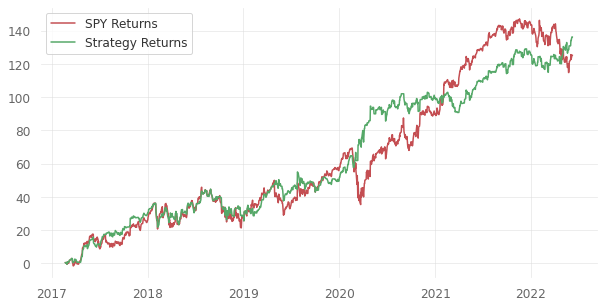

In [24]:
predictors_list = ['MA', 'rsi', '%K', '%D', 'psl', 'rvi', 'true_range', 'pvt', 'pvr', 'mfi']
tree_depth = 3
leaths = 6
leverage = 1
predict_actions_and_plot(prices_indicarors, des_tree(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

[ 1 -1  1 ...  1  1 -1]
(3116, 3) (3116,)
(1336, 3) (1336,)
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       635
           1       0.52      1.00      0.69       701

    accuracy                           0.52      1336
   macro avg       0.26      0.50      0.34      1336
weighted avg       0.28      0.52      0.36      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

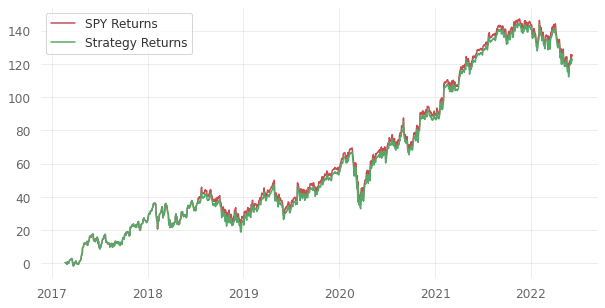

In [25]:
predictors_list = ['Volume', 'true_range','mfi']
tree_depth = 3
leaths = 6
leverage = 1
predict_actions_and_plot(prices_indicarors, des_tree(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

[ 1 -1  1 ...  1  1 -1]
(3116, 7) (3116,)
(1336, 7) (1336,)
              precision    recall  f1-score   support

          -1       0.49      0.36      0.41       635
           1       0.53      0.66      0.59       701

    accuracy                           0.51      1336
   macro avg       0.51      0.51      0.50      1336
weighted avg       0.51      0.51      0.50      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

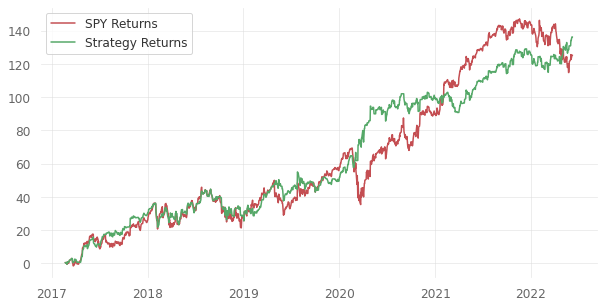

In [69]:
predictors_list = ['MA', 'rsi', '%D', 'rvi', 'pvt', 'pvr', 'Volume']
tree_depth = 3
leaths = 6
leverage = 1
predict_actions_and_plot(prices_indicarors, des_tree(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

# Random Forest

In [56]:
price = yf.download('goog','1993-01-01','2022-12-29')
prices_indicarors = add_indicators(price, 30)
prices_indicarors['return'] = price.Close.pct_change().shift(1).dropna()
prices_indicarors.head()

[*********************100%***********************]  1 of 1 completed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,psl,rvi,true_range,pvt,pvr,mfi,return
Date,,,,,,,,,,,,,,,,,
2004-10-04,67.372475,68.179443,66.764748,67.277824,67.277824,13084661,56.191381,80.823583,95.228059,91.529733,70.000000,13.702702,2.136986,5.512138e+08,2.0,79.111752,0.022994
2004-10-05,67.078575,69.006348,65.873093,68.926643,68.926643,15044379,56.672411,82.763207,99.595842,96.020380,70.000000,20.521805,3.133255,5.880840e+08,1.0,79.915586,0.018706
2004-10-06,68.518173,68.966499,67.746071,68.284058,68.284058,13445007,57.207240,79.392861,96.337472,97.053791,70.000000,18.844187,1.220428,5.755496e+08,4.0,80.608900,0.024508
2004-10-07,68.204353,69.678825,68.020042,69.165749,69.165749,14182160,57.752695,80.562489,97.484123,97.805813,70.000000,25.678482,1.658783,5.938617e+08,1.0,81.313719,-0.009323
2004-10-08,69.100990,69.579201,68.254166,68.607841,68.607841,11122133,58.247839,77.562551,94.748421,96.190005,66.666667,23.481866,1.325035,5.848904e+08,4.0,75.078690,0.012912


(3116, 7) (3116,)
(1336, 7) (1336,)
              precision    recall  f1-score   support

          -1       0.54      0.12      0.20       635
           1       0.53      0.90      0.67       701

    accuracy                           0.53      1336
   macro avg       0.54      0.51      0.44      1336
weighted avg       0.54      0.53      0.45      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

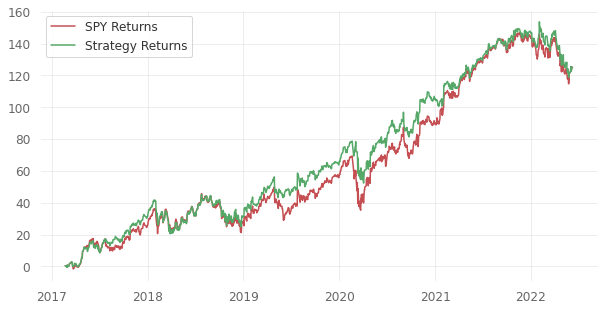

In [28]:
def random_Forest(prices_indicarors, predictors_list, depth, leafs):
  X = prices_indicarors[predictors_list]
  y_cls = make_target(prices_indicarors)

  y=y_cls
  X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=0.3, random_state=432, stratify=y)

  print (X_cls_train.shape, y_cls_train.shape)
  print (X_cls_test.shape, y_cls_test.shape)
  clf = RandomForestClassifier(random_state=5, criterion='gini', max_depth=depth, min_samples_leaf=leafs)
  clf = clf.fit(X_cls_train, y_cls_train)

  y_cls_pred = clf.predict(X_cls_test)
  report = classification_report(y_cls_test, y_cls_pred)
  print(report)
  return y_cls_pred

predictors_list = ['MA', 'rsi', '%D', 'rvi', 'pvt', 'pvr', 'Volume']
tree_depth = 3
leaths = 6
leverage = 1
predict_actions_and_plot(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

(3116, 3) (3116,)
(1336, 3) (1336,)
              precision    recall  f1-score   support

          -1       0.47      0.09      0.16       635
           1       0.52      0.91      0.66       701

    accuracy                           0.52      1336
   macro avg       0.50      0.50      0.41      1336
weighted avg       0.50      0.52      0.42      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

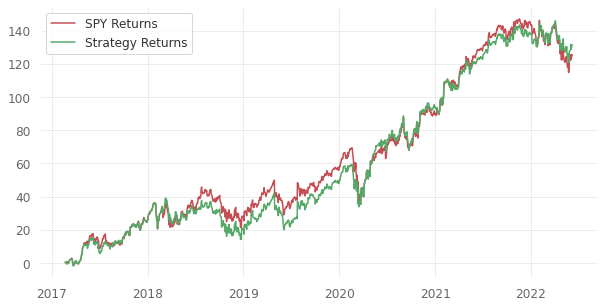

In [65]:
predictors_list = ['Volume', 'true_range','mfi']
tree_depth = 3
leaths = 6
leverage = 1
predict_actions_and_plot(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

(3116, 2) (3116,)
(1336, 2) (1336,)
              precision    recall  f1-score   support

          -1       0.52      0.10      0.17       635
           1       0.53      0.92      0.67       701

    accuracy                           0.53      1336
   macro avg       0.52      0.51      0.42      1336
weighted avg       0.52      0.53      0.43      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

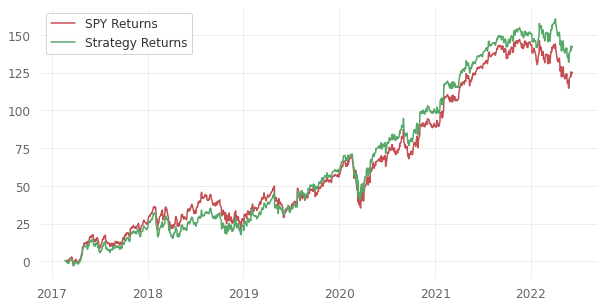

In [63]:
predictors_list = ['Volume','mfi']
tree_depth = 3
leaths = 6
leverage = 1
predict_actions_and_plot(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

(3116, 1) (3116,)
(1336, 1) (1336,)
              precision    recall  f1-score   support

          -1       0.53      0.03      0.05       635
           1       0.53      0.98      0.68       701

    accuracy                           0.53      1336
   macro avg       0.53      0.50      0.37      1336
weighted avg       0.53      0.53      0.38      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

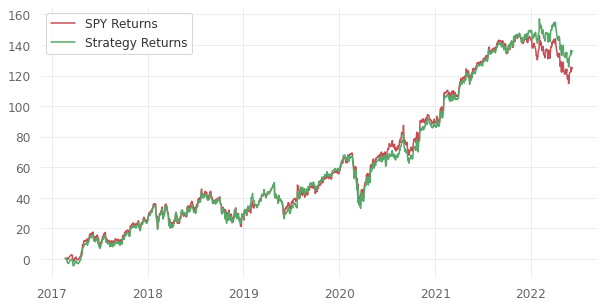

In [61]:
predictors_list = ['mfi']
tree_depth = 1
leafs = 3
leverage = 1
predict_actions_and_plot(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leafs), leverage)

(3116, 2) (3116,)
(1336, 2) (1336,)
              precision    recall  f1-score   support

          -1       0.52      0.10      0.17       635
           1       0.53      0.92      0.67       701

    accuracy                           0.53      1336
   macro avg       0.52      0.51      0.42      1336
weighted avg       0.52      0.53      0.43      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

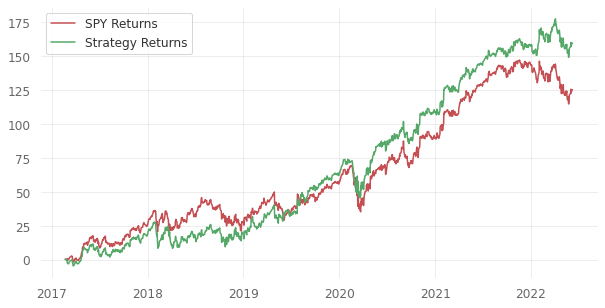

In [57]:
# I will try to plot the best results with short trades
predictors_list = ['Volume','mfi']
tree_depth = 3
leaths = 6
leverage = 1
predict_actions_and_plot_with_short(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

# deep neural network -- Currently not working



In [33]:
prices_indicarors = add_indicators(price, 30)
prices_indicarors['return'] = price.Close.pct_change().shift(1).dropna()
prices_indicarors.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,psl,rvi,true_range,pvt,pvr,mfi,return
Date,,,,,,,,,,,,,,,,,
2004-10-04,67.372475,68.179443,66.764748,67.277824,67.277824,13084661,56.191381,80.823583,95.228059,91.529733,70.000000,13.702702,2.136986,5.512138e+08,2.0,79.111752,0.022994
2004-10-05,67.078575,69.006348,65.873093,68.926643,68.926643,15044379,56.672411,82.763207,99.595842,96.020380,70.000000,20.521805,3.133255,5.880840e+08,1.0,79.915586,0.018706
2004-10-06,68.518173,68.966499,67.746071,68.284058,68.284058,13445007,57.207240,79.392861,96.337472,97.053791,70.000000,18.844187,1.220428,5.755496e+08,4.0,80.608900,0.024508
2004-10-07,68.204353,69.678825,68.020042,69.165749,69.165749,14182160,57.752695,80.562489,97.484123,97.805813,70.000000,25.678482,1.658783,5.938617e+08,1.0,81.313719,-0.009323
2004-10-08,69.100990,69.579201,68.254166,68.607841,68.607841,11122133,58.247839,77.562551,94.748421,96.190005,66.666667,23.481866,1.325035,5.848904e+08,4.0,75.078690,0.012912


In [34]:
X = prices_indicarors
y = make_target(prices_indicarors)

In [35]:
split = int(len(price)*0.7)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [36]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [49]:
classifier = Sequential()

array([ 1, -1,  1, ..., -1, -1, -1])

In [50]:
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 300)


Epoch 1/300
314/314 [==============================] - 2s 3ms/step - loss: 1.0247 - accuracy: 9.5602e-04
Epoch 2/300
314/314 [==============================] - 1s 2ms/step - loss: 0.9992 - accuracy: 0.0000e+00
Epoch 3/300
314/314 [==============================] - 1s 2ms/step - loss: 0.9971 - accuracy: 0.0000e+00
Epoch 4/300
314/314 [==============================] - 1s 2ms/step - loss: 0.9976 - accuracy: 0.0000e+00
Epoch 5/300
314/314 [==============================] - 1s 2ms/step - loss: 0.9946 - accuracy: 0.0000e+00
Epoch 6/300
314/314 [==============================] - 1s 2ms/step - loss: 0.9960 - accuracy: 0.0000e+00
Epoch 7/300
314/314 [==============================] - 1s 2ms/step - loss: 0.9932 - accuracy: 0.0000e+00
Epoch 8/300
314/314 [==============================] - 1s 2ms/step - loss: 0.9937 - accuracy: 0.0000e+00
Epoch 9/300
314/314 [==============================] - 1s 2ms/step - loss: 0.9930 - accuracy: 0.0000e+00
Epoch 10/300
314/314 [==============================] -

In [54]:
y_pred = classifier.predict(X_test)
# y_pred = (y_pred > 0.5)
# pd.DataFrame(y_pred)

y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [40]:
price['y_pred'] = np.NaN
price.iloc[(len(price) - len(y_pred)):,-1:] = y_pred
trade_dataset = price.dropna()
trade_dataset

,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,psl,rvi,true_range,pvt,pvr,mfi,y_pred
Date,,,,,,,,,,,,,,,,,
2017-03-22,831.909973,835.549988,827.179993,829.590027,829.590027,1401500,831.234670,47.026962,52.474708,66.442904,66.666667,61.518244,8.369995,5.514255e+09,4.0,56.818387,False
2017-03-23,821.000000,822.570007,812.257019,817.580017,817.580017,3487100,831.541337,38.370278,26.634055,44.853739,63.333333,58.191201,17.333008,5.509207e+09,3.0,49.923516,False
2017-03-24,820.080017,821.929993,808.890015,814.429993,814.429993,1981000,831.703670,36.473828,12.418695,30.509153,60.000000,55.095113,13.039978,5.508444e+09,4.0,47.994103,False
2017-03-27,806.950012,821.630005,803.369995,819.510010,819.510010,1894300,831.898338,41.495747,32.196316,23.749689,60.000000,57.448659,18.260010,5.509626e+09,2.0,41.652324,False
2017-03-28,820.409973,825.989990,814.026978,820.919983,820.919983,1620500,831.954338,42.846240,35.008949,26.541320,60.000000,59.692393,11.963013,5.509904e+09,2.0,43.175988,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,2283.760010,2357.959961,2266.159912,2354.919922,2354.919922,1373600,2301.788330,53.193528,55.296351,45.084874,46.666667,50.425861,91.800049,5.548818e+09,2.0,62.376534,False
2022-06-03,2319.850098,2327.290039,2273.360107,2291.280029,2291.280029,1252600,2294.872664,48.392867,53.157803,49.532728,46.666667,48.416366,81.559814,5.545433e+09,4.0,56.355646,False
2022-06-06,2334.850098,2387.969971,2330.565918,2340.209961,2340.209961,1189300,2293.136995,51.981128,70.253894,59.569349,50.000000,50.486313,96.689941,5.547973e+09,2.0,61.661123,False


In [41]:
trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


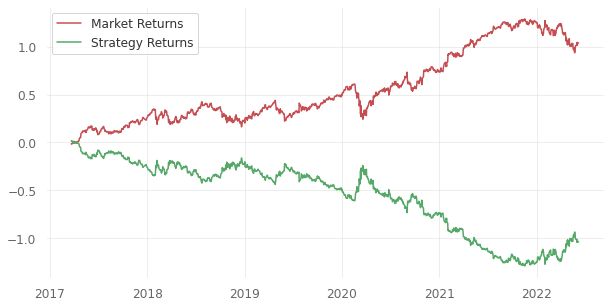

In [44]:
plt.figure(figsize=(10,5))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

# Summery 

From the first look, it seems that some of the models beating the market.
And yet in some cases, there is deeper drawdown in compering with the market
I will take a look at the results of the models to try and figure out where are the problems.

(3116, 2) (3116,)
(1336, 2) (1336,)
              precision    recall  f1-score   support

          -1       0.52      0.10      0.17       635
           1       0.53      0.92      0.67       701

    accuracy                           0.53      1336
   macro avg       0.52      0.51      0.42      1336
weighted avg       0.52      0.53      0.43      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

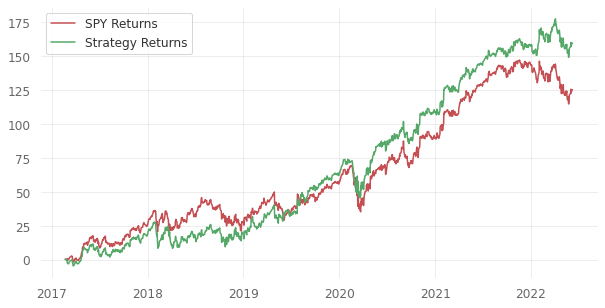

,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,...,pvt,pvr,mfi,return,returns,Predicted_Signal,action,Startegy_returns,Cumulative_Strategy_returns,Cumulative_returns
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-17,823.020020,828.070007,821.655029,828.070007,828.070007,1611000,811.252332,65.709199,73.011847,67.563858,...,5.516490e+09,1.0,72.653123,0.006325,NaN,-1,-1,NaN,NaN,NaN
2017-02-21,828.659973,833.450012,828.349976,831.659973,831.659973,1262300,812.102663,67.748746,79.992144,73.918339,...,5.517038e+09,2.0,82.904698,0.004744,0.004335,1,1,0.004335,0.433534,0.433534
2017-02-22,828.659973,833.250000,828.640015,830.760010,830.760010,982900,812.906329,66.678069,78.242263,77.082085,...,5.516931e+09,4.0,87.572571,0.004335,-0.001082,1,1,-0.001082,0.325321,0.325321
2017-02-23,830.119995,832.460022,822.880005,831.330017,831.330017,1472800,813.790997,67.033431,79.350580,79.194996,...,5.517032e+09,1.0,78.967946,-0.001082,0.000686,1,1,0.000686,0.393934,0.393934
2017-02-24,827.729980,829.000000,824.200012,828.640015,828.640015,1392200,814.481999,63.587026,74.120164,77.237669,...,5.516582e+09,4.0,70.804254,0.000686,-0.003236,1,1,-0.003236,0.070356,0.070356


In [90]:
# best-looking model is a random forset with the following parameters 
predictors_list = ['Volume','mfi']
tree_depth = 3
leaths = 6
leverage = 1
results_vol_mfi = predict_actions_and_plot_with_short(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)
results_vol_mfi.head()

As you can see the strategy returns made more yield and yet until mid-2019 the returns were lower. 
I suspect that the model performs better when there is a bullish market - meaning it has better predictions of positive returns. 

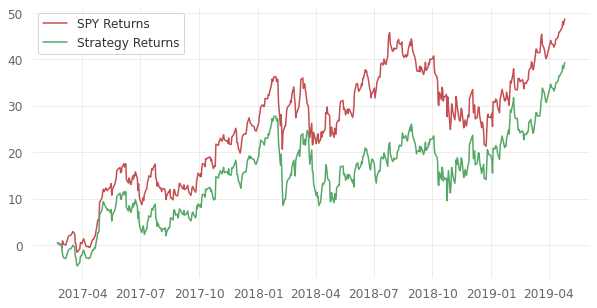

In [102]:

plt.figure(figsize=(10,5))
plt.plot(results_vol_mfi['Cumulative_returns'].iloc[:550], color='r',label = 'SPY Returns')
plt.plot(results_vol_mfi['Cumulative_Strategy_returns'].iloc[:550], color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

It also can bee intresting to understand what happend at June 2019 and August 2019 - How come the strategy comulative return by pass market comulative return


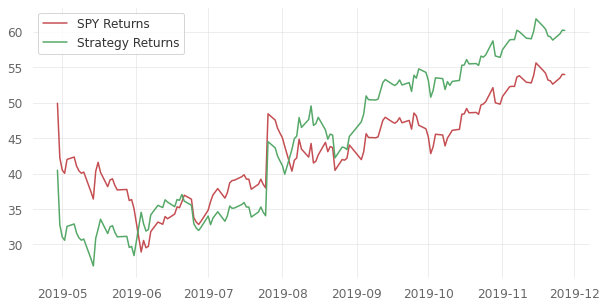

In [104]:
plt.figure(figsize=(10,5))
plt.plot(results_vol_mfi['Cumulative_returns'].iloc[550:700], color='r',label = 'SPY Returns')
plt.plot(results_vol_mfi['Cumulative_Strategy_returns'].iloc[550:700], color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In the following chart we can see the distance in the accumulated returns between the strategy and the market
it looks like the gap is slowly increasing over time


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


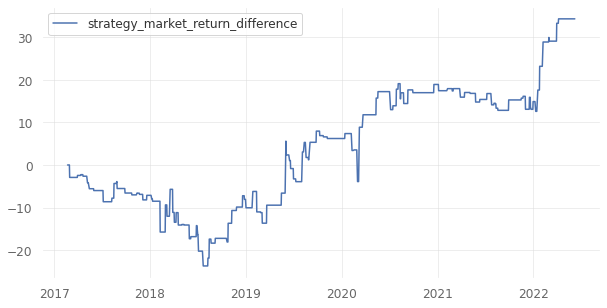

In [103]:

results_vol_mfi['strategy_market_return_difference'] = results_vol_mfi['Cumulative_Strategy_returns'] - results_vol_mfi['Cumulative_returns']
plt.figure(figsize=(10,5))
plt.plot(results_vol_mfi['strategy_market_return_difference'], color='b',label = 'strategy_market_return_difference')
plt.legend()
plt.show()

From the description we can learn that the drawdown of the strategy is higher than -4.5 against -1.6. Once again it indicates that the strategy has a higher risk during bearish moves
Also the Standart deviation is higher which will lower the sharp ratio and kelly criterion 

In [99]:

results_vol_mfi[['returns' ,'Startegy_returns', 'Cumulative_returns', 'Cumulative_Strategy_returns']].describe()


,returns,Startegy_returns,Cumulative_returns,Cumulative_Strategy_returns
count,1335.000000,1335.000000,1335.000000,1335.000000
mean,0.000938,0.001195,64.279483,68.213099
std,0.017765,0.017750,44.260961,56.282782
min,-0.111008,-0.111008,-1.603389,-4.526086
25%,-0.006337,-0.006310,30.173319,18.009151
50%,0.001421,0.001390,47.165411,52.835437
75%,0.009408,0.009435,106.513361,123.904173
max,0.104485,0.104485,147.075028,177.355225


Nothing segnificate cpme to my mind from the correlation 

In [101]:

results_vol_mfi.corr()[results_vol_mfi.corr() > 0.5]

,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,...,pvt,pvr,mfi,return,returns,Predicted_Signal,action,Startegy_returns,Cumulative_Strategy_returns,Cumulative_returns
Open,1.000000,0.999717,0.999667,0.999343,0.999343,NaN,0.992530,NaN,NaN,NaN,...,0.731075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.960730,0.982829
High,0.999717,1.000000,0.999589,0.999671,0.999671,NaN,0.993173,NaN,NaN,NaN,...,0.728788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.962299,0.983926
Low,0.999667,0.999589,1.000000,0.999710,0.999710,NaN,0.991626,NaN,NaN,NaN,...,0.733588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.960219,0.982833
Close,0.999343,0.999671,0.999710,1.000000,1.000000,NaN,0.992253,NaN,NaN,NaN,...,0.731581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.961459,0.983683
Adj Close,0.999343,0.999671,0.999710,1.000000,1.000000,NaN,0.992253,NaN,NaN,NaN,...,0.731581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.961459,0.983683
Volume,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MA,0.992530,0.993173,0.991626,0.992253,0.992253,NaN,1.000000,NaN,NaN,NaN,...,0.710908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.956302,0.975488
rsi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.922429,0.884594,...,NaN,NaN,0.763010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
%K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.922429,1.000000,0.954201,...,NaN,NaN,0.715066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
%D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.884594,0.954201,1.000000,...,NaN,NaN,0.731364,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I want to check how much positive returns there was in the market out of the total returns 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sum_market_neg_days 602, sum_strategy_neg_days 605


sum_positive_predictions 1214, sum_market_pos_days 734. -- Looks like the model almost random


negative_days_sum 602, correct_negative_predictions 60


market_positive_days 734, correct_positive_predictions 672. postive_diff 62


In addition the model predicted to much positive days
And yet the loosing days of the model and the market is almost the same


vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
The algo predicted correctly only 60 out 602 negative return days - just 10%. This is a meaningful down side in the model -- But it seemes that this 10% make all the differnce to gain extra 30% yield
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

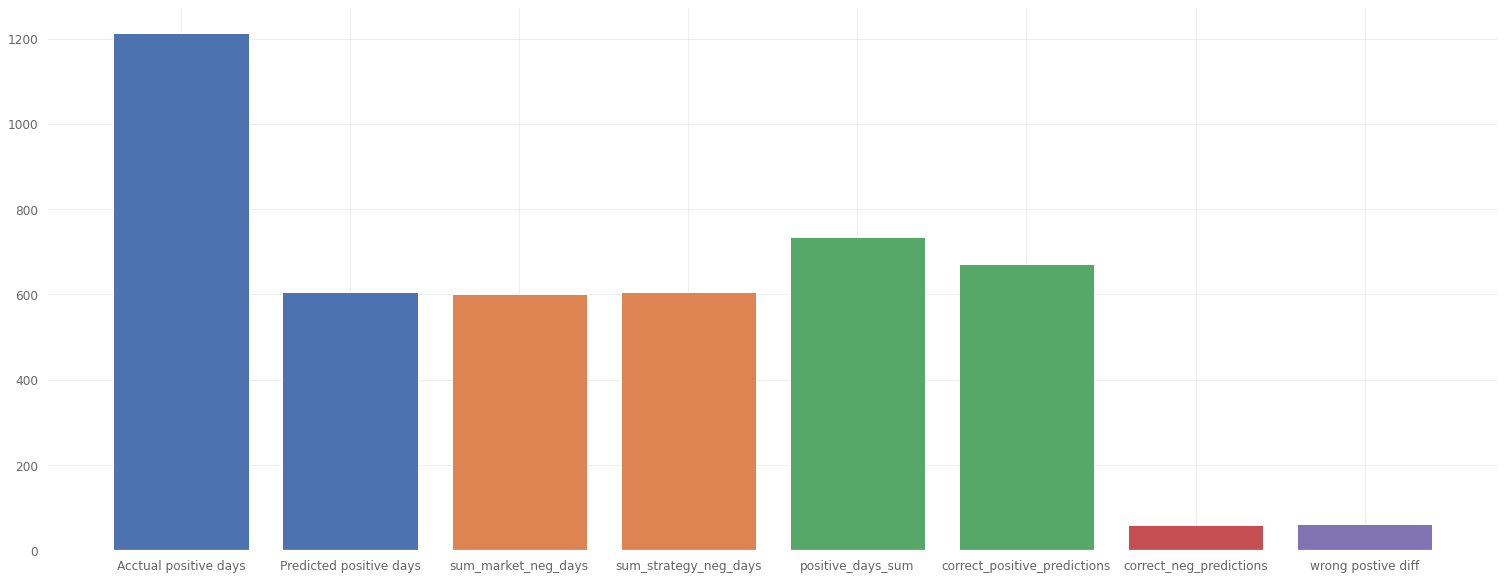

In [158]:
# 
total_days = results_vol_mfi.shape[0]
results_vol_mfi['return_mark'] = np.where(results_vol_mfi['returns'] > 0, 1, 0)
sum_market_pos_days = results_vol_mfi['return_mark'].sum()
sum_market_neg_days = total_days - sum_market_pos_days

sum_strategy_pos_days = np.where(results_vol_mfi['Startegy_returns'] > 0, 1, 0).sum()
sum_strategy_neg_days = total_days - sum_strategy_pos_days
print(f"sum_market_neg_days {sum_market_neg_days}, sum_strategy_neg_days {sum_strategy_neg_days}")
print('\n')
sum_positive_predictions = np.where(results_vol_mfi['Predicted_Signal'] == 1, 1, 0).sum()
print(f"sum_positive_predictions {sum_positive_predictions}, sum_market_pos_days {sum_market_pos_days}. -- Looks like the model almost random")
print('\n')
negative_days = results_vol_mfi[results_vol_mfi['return_mark'] == 0]
negative_days_sum = results_vol_mfi[results_vol_mfi['return_mark'] == 0].shape[0]
correct_negative_predictions = negative_days[negative_days['Predicted_Signal'] == -1]['Predicted_Signal'].shape[0]

print(f"negative_days_sum {negative_days_sum}, correct_negative_predictions {correct_negative_predictions}")
print('\n')

positive_days = results_vol_mfi[results_vol_mfi['return_mark'] == 1]
positive_days_sum = results_vol_mfi[results_vol_mfi['return_mark'] == 1].shape[0]
correct_positive_predictions = positive_days[positive_days['Predicted_Signal'] == 1]['Predicted_Signal'].shape[0]
postive_diff = positive_days_sum - correct_positive_predictions

print(f"market_positive_days {positive_days_sum}, correct_positive_predictions {correct_positive_predictions}. postive_diff {postive_diff}")
print('\n')

plt.figure(figsize=(26, 10))
print('In addition the model predicted to much positive days')
plt.bar(['Acctual positive days','Predicted positive days'], [sum_positive_predictions, sum_strategy_neg_days])
print("And yet the loosing days of the model and the market is almost the same")
plt.bar(['sum_market_neg_days','sum_strategy_neg_days'], [sum_market_neg_days, sum_strategy_neg_days])
plt.bar(['positive_days_sum','correct_positive_predictions'], [positive_days_sum, correct_positive_predictions])
plt.bar(['correct_neg_predictions'], [correct_negative_predictions])
plt.bar(['wrong postive diff'], [postive_diff])

print("\n")
print("v" * 200)
print("The algo predicted correctly only 60 out 602 negative return days - just 10%. This is a meaningful down side in the model -- But it seemes that this 10% make all the differnce to gain extra 30% yield") 
print("^" * 200)
print("\n")

wrong_returns_positive_days -0.5910370090486303 , correct_returns_negative_days 0.7626229525175097
Looks like the profit from correct negative das was higher than the loss of wrong positive days


<BarContainer object of 2 artists>

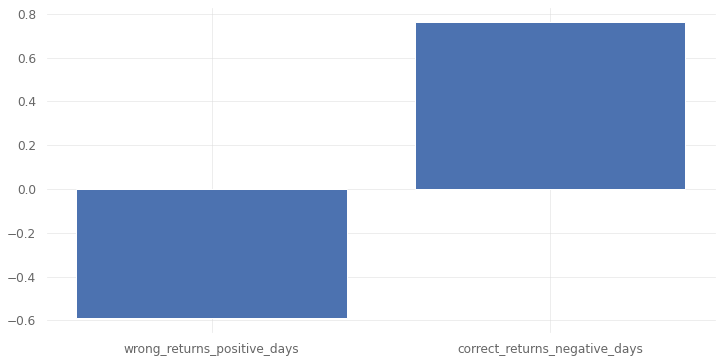

In [172]:
wrong_returns_positive_days = []
correct_returns_negative_days = []
for index, row in results_vol_mfi.iterrows():
  if row.action == -1 and row.returns > 0:
    wrong_returns_positive_days.append(row.Startegy_returns)

  if row.action == -1 and row.returns < 0:
    correct_returns_negative_days.append(row.Startegy_returns)
print(f"wrong_returns_positive_days {sum(wrong_returns_positive_days)} , correct_returns_negative_days {sum(correct_returns_negative_days)}")
print("Looks like the profit from correct negative das was higher than the loss of wrong positive days")

plt.figure(figsize=(12, 6))
plt.bar(['wrong_returns_positive_days', 'correct_returns_negative_days'], [sum(wrong_returns_positive_days), sum(correct_returns_negative_days)])


# I think that the success of this model is just a chance. To confirm the model I have to run it on more assets and test it with a monte Carlo simulation

